In [1]:
# NumPyをインポート（数値計算、行列操作などで使用）
import numpy as np

# NetworkXをインポート（グラフ構造の生成・操作・アルゴリズム適用に利用）
import networkx as nx

# Matplotlibのpyplotモジュールをインポート（グラフの可視化に利用）
import matplotlib.pyplot as plt

In [2]:
# 各コミュニティ間・内部の接続確率を定義（2×2の行列）
# - probs[i][j] はコミュニティ i と j のノード間の接続確率
# 今回は：
# - 同じコミュニティ内の接続確率 = 0.1（対角成分）
# - 異なるコミュニティ間の接続確率 = 0.02（非対角成分）
probs = [
    [0.1, 0.02],
    [0.02, 0.1],
]

# コミュニティ1のノード数（50個）
n1 = 50

# コミュニティ2のノード数（50個）
n2 = 50

# 総ノード数
n = n1 + n2

# ストキャスティック・ブロック・モデル（SBM）に基づくグラフの生成
# - ノード数：[50, 50] → 2つのコミュニティ
# - 接続確率行列：probs
# - seed：再現性のための乱数シード
G = nx.stochastic_block_model([n1, n2], probs, seed=0)  # グラフの生成

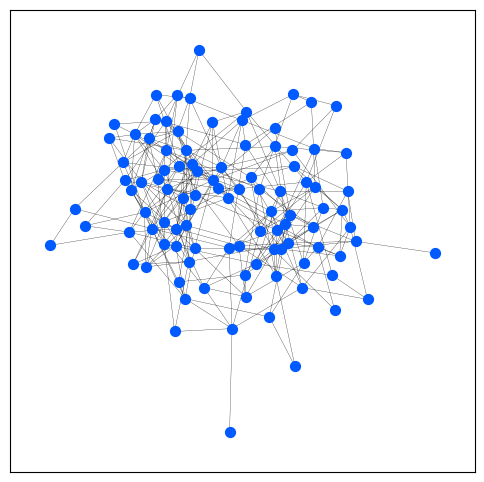

In [3]:
# spring_layout（ばねレイアウト）を使ってノードの描画位置を決定
# - グラフの構造を保ちつつ、ノードが見やすいように配置
# - 引数 seed を指定することで配置の再現性を確保
pos = nx.layout.spring_layout(G, seed=3)

# 描画用のFigureとAxesを作成（正方形のサイズ 6x6インチ）
fig, ax = plt.subplots(figsize=(6, 6))

# グラフを描画（NetworkXの draw_networkx を使用）
nx.draw_networkx(
    G,  # 対象のグラフ
    pos,  # ノードの位置（上で spring_layout により定義）
    ax=ax,  # 描画に使用する Axes オブジェクト
    with_labels=False,  # ノードラベル（番号など）は描画しない
    width=0.2,  # エッジの線の太さ
    node_size=50,  # ノードの大きさ（ピクセル単位）
    node_color="#005aff",  # ノードの色（青系）
)

In [4]:
# 訓練データに用いるノード数を指定（ここでは20個）
nL = 20

# 全ノード n (= 100) からランダムに20個を選び、訓練用ノード集合 L とする
# - replace=False により、同じノードが重複して選ばれることはない
# - np.random.choice によりランダム抽出が行われる（再現性はseed設定が必要）
L = np.random.choice(n, size=nL, replace=False)

# テスト用ノード集合 U を作成
# - 全ノードの集合 set(range(n)) から訓練ノード L を除いたものがテストノード U
# - list(set(...)) で差集合を取り、np.array に変換している
U = np.array(list(set(range(n)) - set(L.tolist())))

In [5]:
# 訓練データ（L）に対応するラベルベクトルを初期化（全て 0 で初期化）
# - サイズ：nL（= 20）
# - データ型：int（整数）
fV = np.zeros(nL, int)

# Lに含まれる各ノード v に対して、確率的にラベルを1に設定（=正例）
for i, v in enumerate(L):
    # v のノードがコミュニティ1（0番目のグループ）に属している場合
    if v < n1:
        p = 0.8  # 正例になる確率を 0.8 に設定（高い確率）
    else:
        p = 0.2  # コミュニティ2の場合は正例になる確率が 0.2（低い確率）

    # 一様乱数（0〜1）を生成して、p 未満なら正例（=1）とする
    if np.random.rand() < p:
        fV[i] = 1  # ラベル 1（正例）を付与

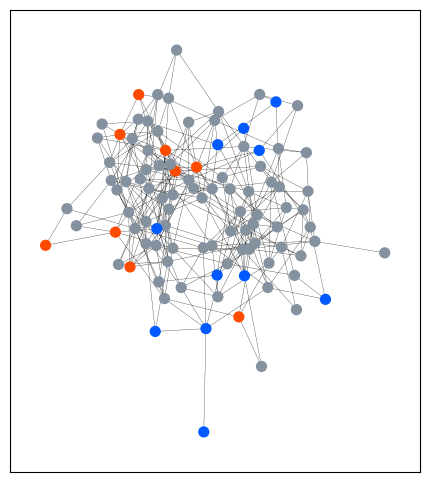

In [6]:
# グラフ可視化用のFigureを作成（横長：幅18インチ × 高さ6インチ）
fig = plt.figure(figsize=(18, 6))

# 1行3列のサブプロットの1つ目（左端）を ax に設定
ax = fig.add_subplot(1, 3, 1)

# ノードの色を格納するリストを初期化（全ノード数分、初期色は0とする）
c = [0 for i in range(n)]

# 各ノード i について、ラベルに応じて色を決定
for i in range(n):
    if i in L and fV[L.tolist().index(i)] == 1:
        # 訓練ノードでラベル1（正例）の場合 → 赤色
        c[i] = "#ff4b00"
    elif i in L and fV[L.tolist().index(i)] == 0:
        # 訓練ノードでラベル0（負例）の場合 → 青色
        c[i] = "#005aff"
    else:
        # テストノード（未ラベル） → グレー
        c[i] = "#84919e"

# ノードのラベル状態を色で可視化してグラフを描画
nx.draw_networkx(
    G,  # グラフ構造
    pos,  # 各ノードの描画位置（spring_layout で生成済み）
    ax=ax,  # 描画先のAxes
    with_labels=False,  # ノードに番号などのラベルは表示しない
    width=0.2,  # エッジの太さ
    node_size=50,  # ノードの大きさ
    node_color=c,  # 上で設定したノードごとの色
)

In [7]:
# グラフ G の隣接行列を取得（scipy.sparse形式 → numpy行列に変換）
# - W[i, j] = 1 ならノード i と j がエッジで繋がっていることを示す
# - .todense() により numpy.matrix 型（密行列）に変換
W = nx.adjacency_matrix(G).todense()  # 隣接行列（Adjacency Matrix）

# 各ノードの次数（=隣接ノードの数）を対角成分に持つ行列 D を作成
# - W.sum(1) により、各行の合計（= 各ノードの次数）を計算
# - np.diag(...) によって、そのベクトルを対角成分とする行列を生成
D = np.diag(W.sum(1))  # 次数行列（Degree Matrix）

In [ ]:
# ラベルなしノード（U）に対して、ラベル付きノード（L）の情報を用いて予測を行う
# 以下の式に基づいて予測値 yhat を計算：
#     ŷ = (D_UU - W_UU)^(-1) × W_UL × fV
#
# - D_UU：ラベルなしノード（U）に対応する次数行列の部分行列
# - W_UU：ラベルなしノード間の隣接行列の部分行列
# - W_UL：ラベルなしノードとラベル付きノード間の隣接行列の部分行列
# - fV：ラベル付きノードのラベルベクトル（長さ nL）

yhat = (
    np.linalg.inv(D[U][:, U] - W[U][:, U])  # 【(D_UU - W_UU)^(-1) の計算】
    # - D[U][:, U]：ラベルなしノードUに対応する次数行列（部分行列）
    # - W[U][:, U]：ラベルなしノードU間の隣接行列（部分行列）
    # - それらの差 D - W はラプラシアン行列（=ノード間のつながりの強さを抑制する項）
    # - np.linalg.inv(...) によってこの行列の逆行列（情報伝播の効果）を計算
    @ W[U][:, L]  # 【W_UL：ラベルなしノードとラベル付きノードの接続関係】
    # - W[U][:, L]：U行L列を取り出すことで、ラベルなしノードUが
    #   ラベル付きノードLとどのようにつながっているかを示す部分隣接行列
    # - @ 演算子は行列積（マトリクスのかけ算）を表す
    #   → A @ B は np.matmul(A, B) と同じ意味
    @ fV  # 【fV：ラベル付きノードのラベルベクトル】
    # - 長さ n_L のラベルベクトル（0 または 1 の分類ラベル）
    # - 上の行列積により、ラベル付きノードからの影響を加重平均して
    #   ラベルなしノードUに対するスコア（=1に近いほど「正例」）を算出
    # 🔸 Pythonの @ 演算子について
    #   - Python 3.5以降で導入された演算子で、NumPy配列（特に2次元）に対する行列積を簡潔に記述できる
    #   - 例： A @ B は np.matmul(A, B) に等しい
    #   - 行列の内積、ベクトルの線形結合、深層学習の線形層などでも広く用いられる
)

# 出力：ラベルなしノードUに対応する予測スコアのベクトル（連続値、0〜1）
yhat

array([0.79357092, 0.83133721, 0.50136156, 0.50659399, 0.6357489 ,
       0.72271717, 0.72778018, 0.65759432, 0.70796885, 0.6189136 ,
       0.63194954, 0.64664606, 0.6544331 , 0.70502962, 0.62685316,
       0.75763478, 0.78344167, 0.49472089, 0.63383183, 0.72347186,
       0.69846919, 0.6528535 , 0.85545412, 0.85173959, 0.84724991,
       0.61806119, 0.72867368, 0.77688083, 0.74613838, 0.61109584,
       0.6211464 , 0.73022012, 0.69834462, 0.52756753, 0.56072084,
       0.6582763 , 0.65898487, 0.74420155, 0.76551853, 0.76443839,
       0.37747274, 0.44929542, 0.23192194, 0.32439649, 0.59277763,
       0.39079285, 0.29197979, 0.27495882, 0.43541419, 0.3950386 ,
       0.31213867, 0.46867117, 0.38948197, 0.42544818, 0.25206058,
       0.38671255, 0.5       , 0.40745212, 0.46277656, 0.56096356,
       0.44929542, 0.55618038, 0.35962255, 0.29303981, 0.24032941,
       0.6261515 , 0.44370525, 0.64847889, 0.43112412, 0.40910717,
       0.31033546, 0.57560861, 0.40001637, 0.42498044, 0.41928

In [9]:
# 描画用サブプロットの2つ目（中央）を作成
ax = fig.add_subplot(1, 3, 2)

# ノードごとの色を格納するリストを初期化（Noneで埋める）
c = [None for i in range(n)]

# 各ノード i に対して色を設定
for i in range(n):
    if i in L and fV[L.tolist().index(i)] == 1:
        # 訓練ノードかつ正例（ラベル1）：赤
        c[i] = "#ff4b00"
    elif i in L and fV[L.tolist().index(i)] == 0:
        # 訓練ノードかつ負例（ラベル0）：青
        c[i] = "#005aff"
    else:
        # テストノードの場合：予測スコア yhat に応じて RGB 色を生成
        p = yhat[U.tolist().index(i)]  # ノード i に対応する予測スコア（0～1）
        c[i] = (
            p,  # 赤成分（スコアが高いほど赤く）
            0.294 * p + 0.353 * (1 - p),  # 緑成分（スコアに応じて中間色へ）
            1 - p,  # 青成分（スコアが低いほど青く）
        )

# 色リストをNumPy配列へ変換（描画用に型を object に設定）
c = np.array(c, dtype=object)

# スコアに応じたノードの色でグラフを描画
nx.draw_networkx(
    G,  # グラフ構造
    pos,  # ノード位置（spring_layout）
    ax=ax,  # 描画先のAxes
    with_labels=False,  # ノード番号などの表示なし
    width=0.2,  # エッジの太さ
    node_size=50,  # ノードの大きさ
    node_color=c,  # ノードの色（上で定義）
)

In [ ]:
# ===============================
# 予測ラベルに基づくグラフの可視化（3番目の図）
# ===============================

# サブプロット3つ目（右側）を作成
ax = fig.add_subplot(1, 3, 3)

# ノードごとの色を格納するリストを初期化（全ノード分、初期値0）
c = [0 for i in range(n)]

# 各ノード i に対して色を決定
for i in range(n):
    if i in L and fV[L.tolist().index(i)] == 1:
        # 訓練ノードかつラベル1（正例） → 赤
        c[i] = "#ff4b00"
    elif i in L and fV[L.tolist().index(i)] == 0:
        # 訓練ノードかつラベル0（負例） → 青
        c[i] = "#005aff"
    else:
        # テストノードに対しては、予測スコア yhat を用いて2値分類
        p = yhat[U.tolist().index(i)]  # ノード i の予測スコアを取得
        if p > 0.5:
            # スコアが 0.5 より大きければ → 正例と判定 → 赤
            c[i] = "#ff4b00"
        else:
            # スコアが 0.5 以下 → 負例と判定 → 青
            c[i] = "#005aff"

# ノードの色に基づいてグラフを描画
nx.draw_networkx(
    G,  # グラフ構造
    pos,  # ノード位置（spring_layout）
    ax=ax,  # 描画先のAxes（右側）
    with_labels=False,  # ノード番号などのラベルは表示しない
    width=0.2,  # エッジの太さ
    node_size=50,  # ノードのサイズ
    node_color=c,  # 上で決定したノードごとの色
)

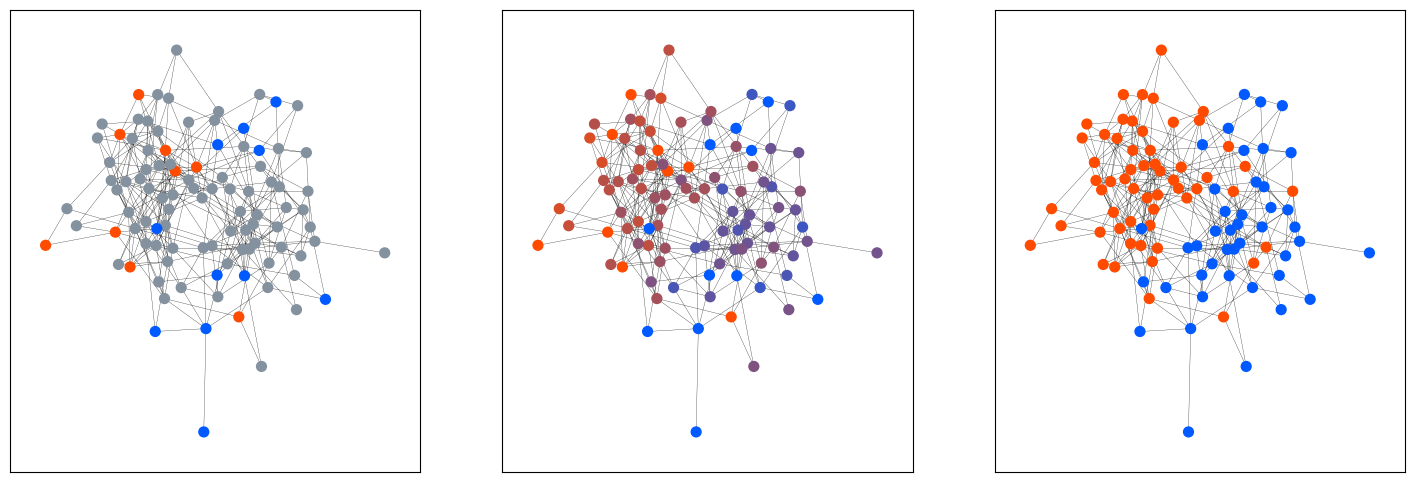

In [11]:
fig